# Installing and Importing Relevant Packages

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.5.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 35.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import torch_geometric as torch_geometric
import math

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
import numpy as np

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data, DataLoader

import torch_geometric.transforms as T

#from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv,GINConv
from torch.distributions import Bernoulli,Categorical
import matplotlib.cm as cmx

# Generating the Dataset

In [ ]:
dataset=[]

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


Total number of nodes generated: 1176


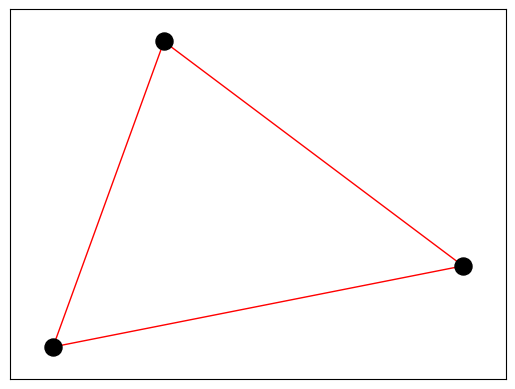

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch_geometric.utils as pyg_utils
import random

num_node_features = 1
totalnode = 0
dataset = []

for _ in range(100):
    num_nodes = random.randint(3, 22)
    totalnode += num_nodes

    Cycle = nx.cycle_graph(num_nodes)
    nx.set_edge_attributes(Cycle, 0, name="Color")

    data = pyg_utils.from_networkx(Cycle)

    x = torch.ones(num_nodes, num_node_features).float()
    data.x = x
    data.y=0

    data.edge_attr = torch.zeros(data.edge_index.size(1), 1)

    dataset.append(data)

    # Visualize the graph with edges colored based on their attributes
edge_colors = ['r' if data.edge_attr[e[2]].item() == 0 else 'g' for e in Cycle.edges(data="Color")]
nx.draw_networkx(Cycle, node_size=150, node_color='black', edge_color=edge_colors, cmap=plt.cm.RdYlGn, with_labels=False)

# Display the total number of nodes generated
print("Total number of nodes generated:", totalnode)


Total number of nodes generated: 1355


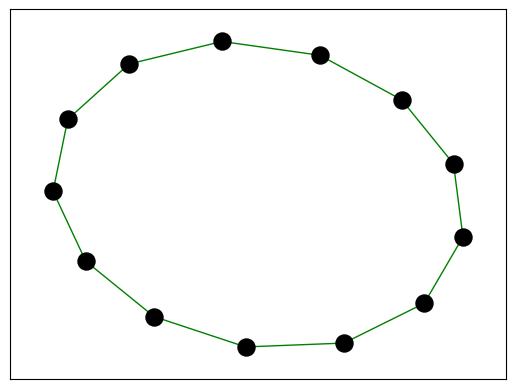

In [ ]:

totalnode=0
for _ in range(100):
    num_nodes = random.randint(3, 22)
    totalnode += num_nodes

    Cycle = nx.cycle_graph(num_nodes)
    nx.set_edge_attributes(Cycle, 1, name="Color")  # Setting edge attribute to 1 for green color

    data = pyg_utils.from_networkx(Cycle)

    x = torch.ones(num_nodes, num_node_features).float()
    data.x = x

    data.edge_attr = torch.ones(data.edge_index.size(1), 1)  # Setting edge attribute to 1
    data.y=1

    dataset.append(data)

    # Visualize the graph with edges colored based on their attributes
    edge_colors = ['r' if data.edge_attr[e[2]].item() == 0 else 'g' for e in Cycle.edges(data="Color")]
nx.draw_networkx(Cycle, node_size=150, node_color='black', edge_color=edge_colors, with_labels=False)

# Display the total number of nodes generated
print("Total number of nodes generated:", totalnode)


Total number of nodes generated: 1266


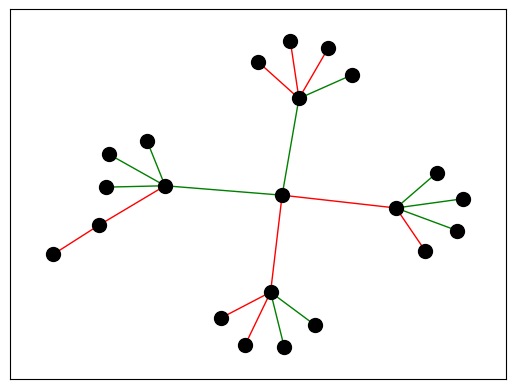

In [ ]:
totalnode=0

for _ in range(100):
    num_nodes = random.randint(3, 22)
    totalnode += num_nodes
    p=math.ceil(random.uniform(2,4))

    # Generate a random tree with the given number of nodes\
    Tree = nx.full_rary_tree(p,num_nodes)

    # Assign random colors to edges while ensuring no fully red or green cycles
    for u, v in Tree.edges():
        if random.random() < 0.5:  # Randomly choose red or green with equal probability
            Tree[u][v]['Color'] = 0  # Red
        else:
            Tree[u][v]['Color'] = 1  # Green

    data = pyg_utils.from_networkx(Tree)

    x = torch.ones(num_nodes, num_node_features).float()
    data.x = x
    # Set all edge attributes to 0 initially
    data.edge_attr = torch.zeros(data.edge_index.size(1), 1)

    # Update edge attributes based on colors assigned to edges in the graph
    for u, v in Tree.edges():
        # Find the indices of the edge (u, v) and (v, u) in data.edge_index
        edge_idx = ((data.edge_index[0] == u) & (data.edge_index[1] == v)) | ((data.edge_index[0] == v) & (data.edge_index[1] == u))

        # Set the edge attributes based on the color assigned to the edge in the graph
        data.edge_attr[edge_idx] = Tree[u][v]['Color']


    data.y=2
    dataset.append(data)
    # print(data.edge_attr)
    # print(len(data.edge_attr))

    # Visualize the graph with edges colored based on their attributes
    edge_colors = ['r' if attr == 0 else 'g' for _, _, attr in Tree.edges(data='Color')]
nx.draw_networkx(Tree, node_size=100, node_color='black', edge_color=edge_colors, with_labels=False)


# Display the total number of nodes generated
print("Total number of nodes generated:", totalnode)


# For Plotting Generated Graphs

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

def draw_graph_from_data(data):
    # Create an empty undirected graph
    G = nx.Graph()

    # Add nodes to the graph
    G.add_nodes_from(range(data.num_nodes))

    # Extract edge attributes from the data object
    edge_attributes = data.edge_attr.numpy().flatten()

    # Iterate over each edge in the edge index
    for edge_index, attr_value in zip(data.edge_index.T, edge_attributes):
        # Unpack the edge indices
        i, j = edge_index

        # Assign color based on edge attribute
        if attr_value == 0:
            edge_color = 'red'
        elif attr_value == 1:
            edge_color = 'green'
        else:
            edge_color = 'black'  # Add default color for other cases

        # Add edge to the graph with color based on edge attribute
        G.add_edge(i.item(), j.item(), color=edge_color)

    # Get edge colors from the graph
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]

    # Draw the graph with edge colors
    nx.draw_networkx(G, with_labels=True, node_color='black', edge_color=edge_colors, width=2, node_size=150)
    plt.show()

# Example usage:
# Assume 'data' is your PyTorch Geometric data object with edge attributes
# Call the function with your data object
# draw_graph_from_data(data)



tensor([[1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.]])
tensor([[ 0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19, 20, 21],
        [ 1,  2,  3,  4,  0,  5,  6,  7,  8,  0,  9, 10, 11, 12,  0, 13, 14, 15,
         16,  0, 17, 18, 19, 20,  1, 21,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,
          3,  4,  4,  4,  4,  5]])


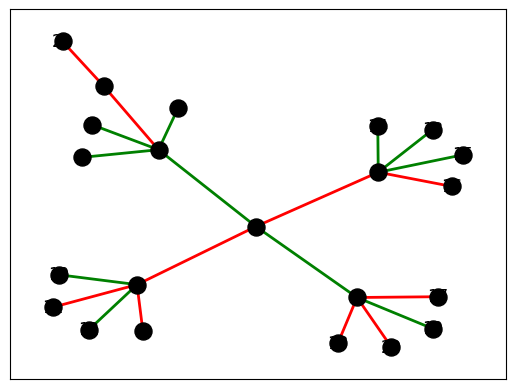

In [ ]:
print(data.edge_attr)
print(data.edge_index)
draw_graph_from_data(data)

# Train-Test Split

In [ ]:
torch.manual_seed(12345)
random.shuffle(dataset)

train_dataset = dataset[:250]
test_dataset = dataset[250:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 250
Number of test graphs: 50


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 1624], Color=[1624], num_nodes=836, x=[836, 1], y=[64], edge_attr=[1624, 1], batch=[836], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 1416], Color=[1416], num_nodes=723, x=[723, 1], edge_attr=[1416, 1], y=[64], batch=[723], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 1492], Color=[1492], num_nodes=766, x=[766, 1], y=[64], edge_attr=[1492, 1], batch=[766], ptr=[65])

Step 4:
Number of graphs in the current batch: 58
DataBatch(edge_index=[2, 1568], Color=[1568], num_nodes=807, x=[807, 1], edge_attr=[1568, 1], y=[58], batch=[807], ptr=[59])



/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Defining and Training the Classifier

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    NNConv,
    global_mean_pool,
    graclus,
    max_pool,
    max_pool_x,
)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        nn1 = nn.Sequential(nn.Linear(1, 25), nn.ReLU(),
                            nn.Linear(25, 1 * 64))
        self.conv1 = NNConv(1, 64, nn1, aggr='mean')

        nn2 = nn.Sequential(nn.Linear(2, 25), nn.ReLU(),
                            nn.Linear(25, 32 * 64))
        self.conv2 = NNConv(32, 64, nn2, aggr='mean')
                # Define MLPs
        self.mlp1 = nn.Sequential(
            nn.Linear(128, 256),  # Increase the number of units
            nn.ReLU(),
            nn.Linear(256, 128)  # Increase the number of units
        )

        self.fc1 = torch.nn.Linear(64, 128)
        self.fc2 = torch.nn.Linear(128, 3)

    def forward(self, data):
        batch=data.batch
        x = F.elu(self.conv1(data.x, data.edge_index, data.edge_attr))
        #weight = normalized_cut_2d(data.edge_index, data.pos)
        #cluster = graclus(data.edge_index, weight, data.x.size(0))
        #data.edge_attr = None
        #data = max_pool(cluster, data, transform=transform)

        #data.x = F.elu(self.conv2(data.x, data.edge_index, data.edge_attr))
        #weight = normalized_cut_2d(data.edge_index, data.pos)
        #cluster = graclus(data.edge_index, weight, data.x.size(0))
        #x, batch = max_pool_x(cluster, data.x, data.batch)

        x = global_mean_pool(x, batch)
        embedding=x
        x = F.elu(self.fc1(x))
        x=self.mlp1(x)
        x = F.dropout(x, training=self.training)

        return embedding,F.log_softmax(self.fc2(x), dim=1)

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import NNConv, global_mean_pool

class NNConvEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels):
        super(NNConvEncoder, self).__init__()
        torch.manual_seed(12345)

        # Define NNConv layers with associated MLPs
        self.nn1 = torch.nn.Sequential(
            Linear(1, 25),
            torch.nn.ReLU(),
            Linear(25, 1 * hidden_channels)
        )
        self.conv1 = NNConv(input_dim, hidden_channels, self.nn1, aggr='mean')

        self.nn2 = torch.nn.Sequential(
            Linear(2, 25),
            torch.nn.ReLU(),
            Linear(25, 32 * hidden_channels)
        )
        self.conv2 = NNConv(32, hidden_channels, self.nn2, aggr='mean')

        # Define additional layers
        self.fc1 = Linear(hidden_channels, hidden_channels * 2)
        self.mlp1 = torch.nn.Sequential(
            Linear(hidden_channels * 2, hidden_channels * 4),
            torch.nn.ReLU(),
            Linear(hidden_channels * 4, hidden_channels * 2)
        )
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x, edge_index, edge_attr, batch):
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = global_mean_pool(x, batch)  # Pooling
        x = F.elu(self.fc1(x))
        x = self.mlp1(x)
        x = self.dropout(x)
        return x


class LinearClassifier(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.linear = Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)


class CombinedModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels, num_classes):
        super(CombinedModel, self).__init__()
        self.encoder = NNConvEncoder(input_dim, hidden_channels)
        self.classifier = LinearClassifier(input_dim=hidden_channels * 2, num_classes=num_classes)

    def forward(self, x, edge_index, edge_attr, batch):
        # Get the embeddings from the encoder
        embeddings = self.encoder(x, edge_index, edge_attr, batch)

        # Get the logits from the classifier
        logits = self.classifier(embeddings)

        return embeddings, logits


# Define model
num_features = 1
input_dim = num_features
model = CombinedModel(input_dim, hidden_channels=64, num_classes=3)


In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

# Add a learning rate scheduler
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.01)

def train():
    model.train()

    for epoch in range(num_epochs):
        for data in train_loader:  # Iterate in batches over the training dataset.
            #print(data)
            embedding,  out = model(data.x, data.edge_index,data.edge_attr,data.batch)  # Perform a single forward pass.
            #print(out)
            loss = criterion(out, data.y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.

        # Update the learning rate scheduler
        scheduler.step()

        # Print the current learning rate every epoch (optional)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss}")
        # train_acc = test(train_loader)
        # test_acc = test(test_loader)
        # print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Set the number of epochs
num_epochs = 700

# Call the training loop
train()



Epoch 1/700, Loss: 0.5997814536094666
Epoch 2/700, Loss: 0.4859946668148041
Epoch 3/700, Loss: 0.1997818499803543
Epoch 4/700, Loss: 0.11548776924610138
Epoch 5/700, Loss: 0.09930116683244705
Epoch 6/700, Loss: 0.08079284429550171
Epoch 7/700, Loss: 0.272344708442688
Epoch 8/700, Loss: 1.4007408618927002
Epoch 9/700, Loss: 0.055143728852272034
Epoch 10/700, Loss: 0.1874973028898239
Epoch 11/700, Loss: 0.44063541293144226
Epoch 12/700, Loss: 0.0339127741754055
Epoch 13/700, Loss: 0.19484438002109528
Epoch 14/700, Loss: 0.07200764864683151
Epoch 15/700, Loss: 0.27901604771614075
Epoch 16/700, Loss: 0.031281568109989166
Epoch 17/700, Loss: 0.4021068215370178
Epoch 18/700, Loss: 0.1818128228187561
Epoch 19/700, Loss: 0.015436426736414433
Epoch 20/700, Loss: 0.09275954961776733
Epoch 21/700, Loss: 0.049938496202230453
Epoch 22/700, Loss: 0.0274224653840065
Epoch 23/700, Loss: 0.17306584119796753
Epoch 24/700, Loss: 0.15591439604759216
Epoch 25/700, Loss: 0.019363708794116974
Epoch 26/700, L

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


def train(epoch):
    model.train()

    if epoch == 16:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.001

    if epoch == 26:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0001

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        embedding,output=model(data)
        F.nll_loss(output, data.y).backward()
        optimizer.step()


def test():
    model.eval()
    correct = 0

    for data in test_loader:
        data = data.to(device)
        _,pred = model(data)
        pred=torch.exp(pred).argmax(dim=1)
        correct += pred.eq(data.y).sum().item()
    return correct / len(test_dataset)


for epoch in range(1, 101):
    train(epoch)
    test_acc = test()
    print(f'Epoch: {epoch:02d}, Test: {test_acc:.4f}')

TypeError: CombinedModel.forward() missing 3 required positional arguments: 'edge_index', 'edge_attr', and 'batch'

In [ ]:
import torch
from sklearn.metrics import f1_score
from torch_geometric.data import DataLoader

def calculate_f1_score(model, dataset):
    model.eval()  # Set model to evaluation mode
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #model.to(device)  # Move model to the appropriate device (GPU if available)

    y_true = []
    y_pred = []

    #loader = DataLoader(dataset, batch_size=1, shuffle=False)
    for data in dataset:
        #data = data.to(device)
        with torch.no_grad():
            _,output = model(data)
        predicted_labels = output.argmax(dim=1)
        y_true.append(data.y)
        y_pred.extend(predicted_labels)

    f1 = f1_score(y_true, y_pred, average=None)  # Calculate F1 score
    return f1
f1=calculate_f1_score(model,dataset)
print(f1)


[0.98522167 0.98039216 0.96373057]


In [ ]:
def degree_distribution(data, N):
    # Find all unique nodes present in the edge index tensor
    all_nodes = torch.unique(torch.cat((data.edge_index[0], data.edge_index[1])))

    # Calculate the number of nodes
    num_nodes = int(all_nodes.max()) + 1 if all_nodes.numel() > 0 else 0  # If there are no nodes, set num_nodes to 0

    # Calculate the degree of each node
    degrees = torch.bincount(data.edge_index[0], minlength=num_nodes)

    # Convert degrees to degree distribution
    degree_values = torch.bincount(degrees)

    # Make sure the tensor is of length N
    degree_distribution = torch.cat((degree_values, torch.zeros(max(N - len(degree_values), 0)).to(degree_values.device)))

    return degree_distribution


def clustering_coefficient(data):
    # Ensure the graph is undirected
    #data = to_undirected(data)

    # Calculate the number of nodes
    num_nodes = data.x.shape[0]

    # Calculate the number of triangles each node is involved in
    num_triangles = torch.zeros(num_nodes, dtype=torch.float)

    # Calculate the number of connected triples each node is involved in
    num_connected_triples = torch.zeros(num_nodes, dtype=torch.float)

    # Iterate over each edge in the graph
    for i, j in data.edge_index.t().tolist():
        # Get the neighbors of node i and node j
        neighbors_i = set(data.edge_index[1][data.edge_index[0] == i].tolist())
        neighbors_j = set(data.edge_index[1][data.edge_index[0] == j].tolist())

        # Calculate the number of common neighbors between i and j
        common_neighbors = neighbors_i.intersection(neighbors_j)

        # Update the number of triangles and connected triples for nodes i and j
        num_triangles[i] += len(common_neighbors)
        num_triangles[j] += len(common_neighbors)
        num_connected_triples[i] += len(neighbors_i) - 1
        num_connected_triples[j] += len(neighbors_j) - 1

    # Print intermediate results for debugging
    #print("Number of triangles per node:", num_triangles)
    #print("Number of connected triples per node:", num_connected_triples)

    # Calculate the local clustering coefficient for each node
    local_clustering_coefficient = (num_triangles / 2) / num_connected_triples
    local_clustering_coefficient[torch.isnan(local_clustering_coefficient)] = 0  # Set NaN values to 0

    # Print intermediate results for debugging
    #print("Local clustering coefficient per node:", local_clustering_coefficient)

    # Calculate the average clustering coefficient
    avg_clustering_coefficient = local_clustering_coefficient.mean()

    return avg_clustering_coefficient
import torch
import torch_geometric
import numpy as np

def spectrum_distribution(data, k):
    # Convert PyTorch Geometric Data object to a dense adjacency matrix
    num_nodes = data.num_nodes
    adj_matrix = torch_geometric.utils.to_dense_adj(data.edge_index).squeeze(0)

    # Calculate degree matrix
    degree = torch.sum(adj_matrix, dim=1)
    degree_matrix = torch.diag(degree)

    # Calculate Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix

    # Convert Laplacian to dense matrix and numpy array
    laplacian_dense = laplacian_matrix.numpy()

    # Compute eigenvalues
    eigenvalues, _ = np.linalg.eig(laplacian_dense)

    # Sort eigenvalues in ascending order
    eigenvalues = np.sort(eigenvalues)

    # If k is greater than the number of eigenvalues, pad with zeros
    if k > len(eigenvalues):
        padded_eigenvalues = np.pad(eigenvalues, (0, k - len(eigenvalues)), 'constant')
    else:
        padded_eigenvalues = eigenvalues[:k]

    return padded_eigenvalues.astype(np.complex128)




In [ ]:
# Separating the graphs into two classes according to the model
N=25
data1=[]
data2=[]
data3=[]
latent1=[]
latent2=[]
latent3=[]
degreedist1=[]
degreedist2=[]
degreedist3=[]
cluscoeff1=[]
cluscoeff2=[]
cluscoeff3=[]
spec1=[]
spec2=[]
spec3=[]

for i in range(len(dataset)):
    model.eval()
    data=dataset[i]
    embedding , out = model(data)
    pred = out.argmax(dim=1)
    if(pred==0):
        data1.append(data)
        latent1.append(embedding)
        degree=degree_distribution(data,N)
        clus=clustering_coefficient(data)
        spec=spectrum_distribution(data,N)
        cluscoeff1.append(clus)
        degreedist1.append(degree)
        spec1.append(spec)

    if(pred==1):
        data2.append(data)
        latent2.append(embedding)
        degree=degree_distribution(data,N)
        degreedist2.append(degree)
        clus=clustering_coefficient(data)
        cluscoeff2.append(clus)
        spec=spectrum_distribution(data,N)
        spec2.append(spec)
    if(pred==2):
        data3.append(data)
        latent3.append(embedding)
        degree=degree_distribution(data,N)
        degreedist3.append(degree)
        clus=clustering_coefficient(data)
        cluscoeff3.append(clus)
        spec=spectrum_distribution(data,N)
        spec3.append(spec)
print(len(data1))
print(len(data2))
print(len(data3))

print(data.batch)

latent_explanations=[]


103
104
93
None


# Plotting the Confusion Matrix of the Classifier

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, dataset, class_dict):
    """
    Evaluate the model on the provided dataset, compute the confusion matrix,
    and plot it with class names.

    Parameters:
    - model: Trained GNN model
    - dataset: List of data objects
    - class_dict: Dictionary mapping class labels to class names, e.g., {0: 'Class A', 1: 'Class B'}
    """

    # Step 1: Evaluate the model and get predictions and true labels
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in dataset:
            _, out = model(data.x,data.edge_index,data.edge_attr,None)
            pred = out.argmax(dim=1)
            data.y=torch.tensor(data.y)
            all_preds.append(pred.numpy().flatten())
            all_labels.append(data.y.numpy().flatten())

    print(all_labels)
    print(all_preds)
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Step 2: Compute the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Step 3: Plot the confusion matrix
    class_names = [class_dict[i] for i in range(len(class_dict))]

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Example usage:
# Assuming the class labels are {0: 'Mutagenic', 1: 'Non-Mutagenic'}
#class_dict = {0: 'Mutagenic', 1: 'Non-Mutagenic'}

# Example dataset (assuming it's a list of data objects)
# dataset = [...]

# Call the function with the model, dataset (as a list), and class dictionary
#plot_confusion_matrix(model, dataset, class_dict)


<ipython-input-53-b5e0b8526493>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.y=torch.tensor(data.y)


[array([1]), array([1]), array([0]), array([1]), array([1]), array([2]), array([0]), array([2]), array([0]), array([2]), array([2]), array([0]), array([2]), array([0]), array([1]), array([0]), array([0]), array([1]), array([2]), array([0]), array([1]), array([0]), array([0]), array([1]), array([2]), array([1]), array([0]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([1]), array([2]), array([0]), array([2]), array([0]), array([2]), array([2]), array([2]), array([0]), array([1]), array([2]), array([2]), array([0]), array([2]), array([1]), array([1]), array([1]), array([2]), array([0]), array([1]), array([2]), array([2]), array([0]), array([2]), array([2]), array([1]), array([2]), array([0]), array([1]), array([1]), array([0]), array([2]), array([0]), array([2]), array([1]), array([1]), array([0]), array([2]), array([1]), array([0]), array([2]), array([2]), array([2]), array([0]), array([0]), array([1]), array([2]), array([2]), array([1]), array([2]), arr

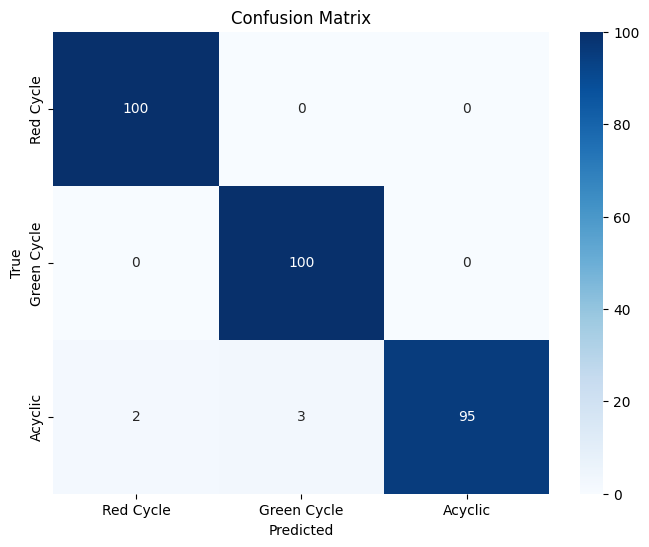

In [ ]:
class_dict={0:'Red Cycle',1:'Green Cycle',2:'Acyclic'}
plot_confusion_matrix(model,dataset,class_dict)

In [ ]:
N=25
def GraphRep(N,classdata):
  from tqdm import tqdm
  X=np.zeros((N,2))# Node Type Matrix for nodes of 10 types
  targetclass=classdata
  print("length of target class",len(targetclass))

  #Learning the node representations
  for i in tqdm(range(len(targetclass))):#len(data1))
      data=targetclass[i]
      x=data.x
      x=np.array(x,dtype=int)

      #print(x)
      for j in range(len(x)):
          X[j][x[j]]+=1
      for k in range(j+1,N):
          X[k][0]+=1

  #Learning the edge representations
  Adj=np.zeros((N,N,3))# Edge type count for three types of edges absent/red/green
  for i in tqdm(range(len(targetclass))):
      data=targetclass[i]
      adj=data.edge_index
      edgecolor=data.edge_attr
      rowlen=len(adj[0][:])
      #print(rowlen)
      #print(adj[:][0])
      #print(adj[:][1])
      for j in range(rowlen):
          k1=adj[0][j]
          k2=adj[1][j]
          if(edgecolor[j]==0):
            Adj[k1][k2][1]+=1
            Adj[k1][k2][0]-=1
          else:
            Adj[k1][k2][2]+=1
            Adj[k1][k2][0]-=1

          #Adj[k2][k1]+=1


  #Learning the parameters for the distribution of nodes
  numgraphs=len(targetclass)
  print(numgraphs)
  Adj[:,:,0]=Adj[:,:,0]+numgraphs

  X=X/numgraphs #converting X to the node distribution matrix

  Adj=Adj/numgraphs
  return X, Adj



In [ ]:
X1,Adj1=GraphRep(N,data1)
X2,Adj2=GraphRep(N,data2)
X3,Adj3=GraphRep(N,data3)
AllX=[X1,X2,X3]
AllAdj=[Adj1,Adj2,Adj3]

length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1573.17it/s]


103
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1268.77it/s]


104
length of target class 93


100%|██████████| 93/93 [00:00<00:00, 1442.71it/s]

93


In [ ]:
accuracy=[]
density=[]
latent_explanations=[]

In [ ]:


def extract_edge_attributes(edge_index, edge_attribute_matrix):
    edge_attributes = []
    # Iterate over each edge in the PyTorch Geometric data object
    for i, j in edge_index.T:
        # Retrieve the value from the edge attribute matrix
        value = edge_attribute_matrix[i][j]
        # Append the value to the list of edge attributes
        edge_attributes.append(value)
    return torch.tensor(edge_attributes).view(-1, 1)  # Convert to tensor and reshape

# Example usage
# Let's assume 'data' is your PyTorch Geometric data object
# Let 'edge_attribute_matrix' be your NXN matrix containing edge attributes
# Ensure that 'data' already has 'edge_index' initialized properly

# Extract edge attributes
# edge_attributes = extract_edge_attributes(data, edge_attribute_matrix)



In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

def draw_graph_from_data(data):
    # Create an empty undirected graph
    G = nx.Graph()

    # Add nodes to the graph
    G.add_nodes_from(range(data.num_nodes))

    # Extract edge attributes from the data object
    edge_attributes = data.edge_attr.numpy().flatten()

    # Iterate over each edge in the edge index
    for i, j in data.edge_index.T:
        # Add edges to the graph with color based on edge attribute
        if edge_attributes[i] == 0 and edge_attributes[j] == 0:
            G.add_edge(i.item(), j.item(), color='red')
        elif edge_attributes[i] == 1 and edge_attributes[j] == 1:
            G.add_edge(i.item(), j.item(), color='green')

    # Get edge colors from the graph
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]

    # Draw the graph with edge colors
    nx.draw_networkx(G, with_labels=True, node_color='black', edge_color=edge_colors, width=2, node_size=150)
    plt.show()

# Example usage:
# Assume 'data' is your PyTorch Geometric data object with edge attributes
# Call the function with your data object
# draw_graph_from_data(data)


In [ ]:
from torch.distributions import Categorical
import torch.distributions as dist
from torch_geometric.utils import subgraph
from torch_geometric.utils import remove_isolated_nodes
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
def GraphSampler(N,X,Adj,show=False):
  nodeset=[]
  keepnodes=[]
  newnodes=[]
  count=0


  for i in range(N):
      probs=X[i][:]
      probs=torch.from_numpy(probs)
      m=Categorical(probs)
      chosennode=m.sample()
      nodeset.append(chosennode)
      if(chosennode!=0):
          keepnodes.append(i)
          newnodes.append(chosennode)
  # print("Whole set of nodes ")
  # print(nodeset)
  # print("Nodes to keep")
  # print(keepnodes)
  # print(newnodes)
  #print(Adjacency)
  keepnodescp=keepnodes.copy()

  # Adj1=torch.from_numpy(Adj)
  # Adjacency= torch.categorical(Adj1)
  Adjacency=np.zeros((N,N))# sampled adjacency matrix
  Edgecolor=np.zeros((N,N))
  for i in range(N):
    for j in range(i+1):
      p=Adj[i][j][:]
      #print(p)
      sample=np.random.choice([0, 1, 2], p=p)
      if(sample==1):
        Adjacency[i][j]=1
        Edgecolor[i][j]=1
      if(sample==2):
        Adjacency[i][j]=1
        Edgecolor[i][j]=2
      if(sample==0):
        Adjacency[i][j]=0
        Edgecolor[i][j]=0
      #Adjacency[i][j]=1 if sample!=0 else 0

  #Symmetrizing the adjacency matrix as it is a dataset of undirected graphs
  #print("Adjacency matrix before symmetrizing",Adjacency)
  for i in range(N):
    for j in range(i+1):
      Adjacency[j][i]=Adjacency[i][j]
      Edgecolor[j][i]=Edgecolor[i][j]
  #print(Adjacency.size())
  # Removing edges generated for absent nodes
  for i in range(len(nodeset)):
    if(nodeset[i]==0):

      Adjacency[i][:]=0
      Adjacency[:][i]=0
      Edgecolor[i][:]=0
      Edgecolor[:][i]=0

  #print("Length of keepnodes list",len(keepnodes))

  templen =  len(keepnodes)
  for j in range(templen):
    testval=0
  # print("value of loop counter j",j)
    place=keepnodes[j]
    #print("corresponding keepnode value",place)
    for k in range(10):
      if(Adjacency[place][k]!=0):
        testval=1
        break
    if(testval==0):
      keepnodescp.remove(place)




  # To test how potent the explainer is we need to feed samples generated from this to the GNN to classify
  #First we need to convert the data into the tensor proper for fitting into the GNN
  Adjacency=torch.tensor(Adjacency)
  edge_ind=Adjacency.nonzero().t().contiguous()
  Edgecolor=Edgecolor-1
  edgeattr=extract_edge_attributes(edge_ind,Edgecolor)
  newgraph=Data(x=nodeset,edge_index=edge_ind,edge_attr=Edgecolor)
  # print("Edge index of graph with all nodes")
  # print(edge_ind)
  # #print(newgraph.x)


  # print("Finally nodes that remain in the graph")
  # print(keepnodescp)

  extractededge=subgraph(keepnodescp,edge_ind,edge_attr=edgeattr,relabel_nodes=True)
  extedge=subgraph(keepnodescp,edge_ind,relabel_nodes=False)

  # print("Final edges with nodes same as before")
  # print(extedge[0])
  # print("Final edges with relabelled nodes")
  # print(extractededge[0])


  newnodes1=[nodeset[i] for i in keepnodescp]
  newnodes=newnodes1
  x1=torch.ones(len(newnodes),1)
  x1=x1.float()
  #print(newnodes)
  newnodes=torch.stack(newnodes)

  #print(newnodes)

  newnodes=newnodes.float()

  #print(newnodes)
  edge_attr=extractededge[1]
  # print(" Length of Edge attribute is",len(edge_attr))
  # print("Edge Attributes is",edge_attr)
  edge_attr=edge_attr.float()
  finalgraph=Data(x=x1,edge_index=extractededge[0],edge_attr=edge_attr)
  #print(finalgraph.edge_index)


  # print(finalgraph.edge_index.size())
  # print(finalgraph.edge_attr.size())
  embedding,out=model(finalgraph.x,finalgraph.edge_index,finalgraph.edge_attr,None)
  #print(embedding)
  #print(out
  # soft=torch.nn.Softmax(dim=1)
  # print(soft(out))
  # print(out)
  explainergraph=to_networkx(finalgraph,to_undirected=True)
  problities=torch.exp(out)
  degreedist=degree_distribution(finalgraph,N)
  cluscoeffexp=clustering_coefficient(finalgraph)
  specdist=spectrum_distribution(finalgraph,N)


  #nx.draw_networkx(explainergraph, node_size=150,nod edge_color='green',with_labels=False)
  #nx.draw_networkx(explainergraph, node_size=150, node_color='black',edge_color='red',with_labels=False)
  if show:
    draw_graph_from_data(finalgraph)
  explainernodes=nx.number_of_nodes(explainergraph)
  explaineredges=nx.number_of_edges(explainergraph)
  explainerdensity=(explaineredges)/(explainernodes*explainernodes)
  return problities, explainerdensity, embedding, degreedist, cluscoeffexp, specdist


In [ ]:
import torch

def mmd_kernel(X, Y, kernel_func):
    """
    Compute Maximum Mean Discrepancy (MMD) between two samples using a given kernel function.

    Parameters:
    - X: torch.Tensor, shape (n_samples, n_features)
    - Y: torch.Tensor, shape (m_samples, n_features)
    - kernel_func: function, kernel function to compute pairwise kernel values

    Returns:
    - mmd: float, Maximum Mean Discrepancy
    """
    m, n = len(X), len(Y)

    # Compute kernel matrices
    K_xx = kernel_func(X, X)
    K_yy = kernel_func(Y, Y)
    K_xy = kernel_func(X, Y)

    # Compute MMD statistic
    mmd = 1.0 / (m * (m - 1)) * torch.sum(K_xx - torch.diag(torch.diagonal(K_xx))) + \
          1.0 / (n * (n - 1)) * torch.sum(K_yy - torch.diag(torch.diagonal(K_yy))) - \
          2.0 / (m * n) * torch.sum(K_xy)

    return mmd.item()  # Convert the result to a Python float

# Example of using a Gaussian (RBF) kernel function for PyTorch
def gaussian_kernel(X, Y, sigma=1.0):
    """
    Gaussian (RBF) kernel function.

    Parameters:
    - X: torch.Tensor, shape (n_samples, n_features)
    - Y: torch.Tensor, shape (m_samples, n_features)
    - sigma: float, bandwidth parameter of the kernel

    Returns:
    - K: torch.Tensor, shape (n_samples, m_samples), kernel matrix
    """
    pairwise_sq_dists = torch.sum(X**2, dim=1, keepdim=True) + torch.sum(Y**2, dim=1, keepdim=True).t() - 2 * torch.mm(X, Y.t())
    K = torch.exp(-pairwise_sq_dists / (2.0 * sigma**2))
    return K

# Example usage with PyTorch tensors
torch.manual_seed(42)
sample_X = torch.rand(100, 64)  # Replace with your first sample
sample_Y = torch.rand(50, 64)  # Replace with your second sample

mmd_value = mmd_kernel(sample_X, sample_Y, gaussian_kernel)
print(f'MMD between the two samples: {mmd_value:.4f}')


MMD between the two samples: 0.0001


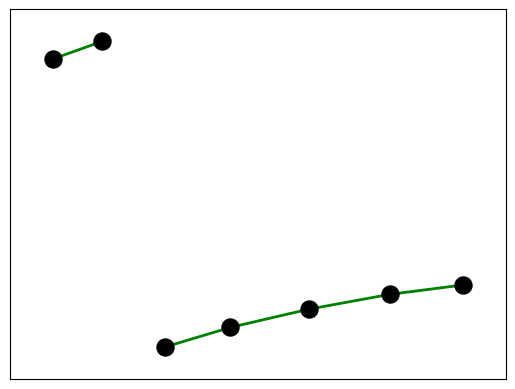

tensor([[2.6503e-03, 6.3491e+01, 1.3754e+00]], grad_fn=<ExpBackward0>)


In [ ]:
problities,*_=GraphSampler(N,X2,Adj2,show=True)
print(problities)

In [ ]:
import statistics
def robustnessanalysis(X,Adj,N,latent,numsample,label=0):
  epsilon=0.01
  alpha=0.0
  perturbedX=X#perturbX(X,epsilon)
  perturbedAdj=Adj#perturbadj(Adj,epsilon)
  meanaccuracy=[]
  stdaccuracy=[]
  meandensity=[]
  stddensity=[]
  MMD=[]

  while(alpha<0.1):
    accuracy=[]
    density=[]
    embeddings=[]
    degreedistlist=[]
    cluslist=[]
    speclist=[]
    for i in range(100):
      newX=X#nodefeatcomb(perturbedX,X,alpha)
      newAdj=Adj#adjcomb(perturbedAdj,Adj,alpha)
      max=0
      for num in range(numsample):
        problities,explainerdensity,embedding,degreedistb,clus,spec=GraphSampler(N,newX,newAdj)
        #max=problities[0][label]
        if(problities[0][label]>max):
          sampleaccuracy=problities[0][label]
          sampledensity=explainerdensity
          sampleembedding=embedding
          sampledeg=degreedistb
          sampleclus=clus
          samplespec=spec
          max=problities[0][label]
      accuracy.append(sampleaccuracy)
      density.append(sampledensity)
      embeddings.append(sampleembedding)
      degreedistlist.append(sampledeg)
      cluslist.append(sampleclus)
      speclist.append(samplespec)
    meanacc=torch.mean(torch.stack(accuracy))
    stdacc=torch.std(torch.stack(accuracy))
    meanden=statistics.mean(density)
    stdden=statistics.stdev(density)
    meanaccuracy.append(meanacc)
    stdaccuracy.append(stdacc)
    meandensity.append(meanden)
    stddensity.append(stdden)
    MMDdist=mmd_kernel(torch.cat(latent,dim=0),torch.cat(embeddings,dim=0),gaussian_kernel)
    MMD.append(MMDdist)
    alpha+=0.05
  return meanaccuracy , stdaccuracy, meandensity, stddensity, MMD, degreedistlist,cluslist,speclist





In [ ]:
import time
start_time = time.time()
meanacc,stdacc, meandensity, stddensity, MMD, deg,cluslist,speclist   =robustnessanalysis(X3,Adj3,N,latent3,4,2)
print("--- %s seconds ---" % (time.time() - start_time))



--- 15.817933082580566 seconds ---


In [ ]:
print("Accuracy is",meanacc,"std is",stdacc)
print("Density is", meandensity,"std is",stddensity)
print("MMD is",MMD)

Accuracy is [tensor(0.9990, grad_fn=<MeanBackward0>), tensor(0.9991, grad_fn=<MeanBackward0>)] std is [tensor(0.0002, grad_fn=<StdBackward0>), tensor(0.0001, grad_fn=<StdBackward0>)]
Density is [0.10321395362393739, 0.10038956496345565] std is [0.020378714893193716, 0.019354687760983428]
MMD is [0.025209546089172363, 0.03089118003845215]


In [ ]:
import torch

def nptotensor(numpy_array_list):
    """
    Convert a list of NumPy arrays to a list of PyTorch tensors.

    Args:
        numpy_array_list (list): List of NumPy arrays.

    Returns:
        list: List of PyTorch tensors.
    """
    return list(map(torch.tensor, numpy_array_list))


MMDdegdist=mmd_kernel(torch.cat(degreedist3,dim=0).view(-1,N),torch.cat(deg,dim=0).view(-1,N),gaussian_kernel)
print(MMDdegdist)
MMDdistclus=mmd_kernel(torch.stack(cluscoeff3).view(-1,1),torch.stack(cluslist).view(-1,1),gaussian_kernel)
print(MMDdistclus)
MMDspec=mmd_kernel(torch.cat(nptotensor(spec3),dim=0).view(-1,N),torch.cat(nptotensor(speclist),dim=0).view(-1,N),gaussian_kernel)
print(MMDspec)

0.044310521334409714
0.0004153251647949219
(0.033308106976327766-5.276031053364263e-21j)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_with_error(mean, std, threshold, label, numsample,title=None, ax=None):
    """
    Plot mean with error bars.

    Parameters:
        mean (array_like): Array containing mean values.
        std (array_like): Array containing standard deviation values.
        threshold (array_like): Array containing threshold values.
        label (str): Label for the data.
        color (str): Color of the line.
        numsample (int): Sample number.
        ax (matplotlib.axes.Axes, optional): Axes object to plot on. If not provided, a new figure will be created.
    """
    # Flatten the arrays
    mean=torch.tensor(mean,dtype=torch.float32)
    std=torch.tensor(std,dtype=torch.float32)
    mean = np.array(mean).flatten()
    std = np.array(std).flatten()
    threshold = np.array(threshold).flatten()
    # Select color automatically
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    color = colors[numsample % 10]  # Cycle through colors

    # Plotting
    if ax is None:
        fig, ax = plt.subplots()
    ax.errorbar(threshold, mean, yerr=std, fmt='-', color=color, label=f'NumSample={numsample}')  # '-' for line

    # Adding labels and title
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Accuracy')
    ax.set_title(title)

    ax.legend(loc='lower right',fontsize='small')  # Show legend
    ax.grid(True)  # Add grid
# Create a figure outside the function
# fig, ax = plt.subplots()
# plot_mean_with_error(Mean1,Std1,Threshold,label='class1',numsample=1,ax=ax)
# plot_mean_with_error(Mean2,Std2,Threshold,label='class1',numsample=2,ax=ax)
# plt.show()


In [ ]:
def Dpc(dataset,threshold):
  boundary1=[]
  boundary2=[]
  boundary3=[]
  m=torch.nn.Softmax(dim=1)
  for i in range(len(dataset)):
      model.eval()
      data=dataset[i]
      embedding , out = model(data)
      probs=m(out)
      #out=torch.nn.Softmax(out,dim=0)
      #pred = out.argmax(dim=1)
      if(threshold<probs[0][0]):
          boundary1.append(data)
          #latent_data1.append(embedding)
      if(threshold <probs[0][1]):
          boundary2.append(data)
      if(threshold<probs[0][2]):
          boundary3.append(data)
  return boundary1 , boundary2, boundary3


In [ ]:
import statistics
def sensitivityanalysis(X,Adj,N,numsample,label=0):
  epsilon=0.01
  alpha=0.0
  # perturbedX=perturbX(X,epsilon)
  # perturbedAdj=perturbadj(Adj,epsilon)
  meanaccuracy=[]
  stdaccuracy=[]
  meandensity=[]
  stddensity=[]
  MMD=[]

  while(alpha==0.0):
    accuracy=[]
    density=[]
    embeddings=[]
    for i in range(100):
      newX=X#nodefeatcomb(perturbedX,X,alpha)
      newAdj=Adj#adjcomb(perturbedAdj,Adj,alpha)
      max=0
      for num in range(numsample):
        problities,explainerdensity,embedding=GraphSampler(N,newX,newAdj)
        #max=problities[0][label]
        if(problities[0][label]>max):
          sampleaccuracy=problities[0][label]
          sampledensity=explainerdensity
          sampleembedding=embedding
          max=problities[0][label]
      accuracy.append(sampleaccuracy)
      density.append(sampledensity)
      embeddings.append(sampleembedding)
    meanacc=torch.mean(torch.stack(accuracy))
    stdacc=torch.std(torch.stack(accuracy))
    # meanden=statistics.mean(density)
    # stdden=statistics.stdev(density)
    meanaccuracy.append(meanacc)
    stdaccuracy.append(stdacc)
    # meandensity.append(meanden)
    # stddensity.append(stdden)
    # MMDdist=mmd_kernel(torch.cat(latent,dim=0),torch.cat(embeddings,dim=0),gaussian_kernel)
    # MMD.append(MMDdist)
    alpha+=0.05
  return meanaccuracy , stdaccuracy

length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1534.04it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1181.25it/s]


103
length of target class 93


100%|██████████| 93/93 [00:00<00:00, 1394.13it/s]


93
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1524.76it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1454.96it/s]


103
length of target class 93


100%|██████████| 93/93 [00:00<00:00, 1564.23it/s]


93
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1540.41it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1249.43it/s]


103
length of target class 93


100%|██████████| 93/93 [00:00<00:00, 1513.04it/s]


93
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1474.05it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1419.18it/s]


103
length of target class 93


100%|██████████| 93/93 [00:00<00:00, 1402.30it/s]


93
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1640.72it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1535.28it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1543.99it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1424.16it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1534.93it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1484.97it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1331.99it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1503.29it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1571.85it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1525.83it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1504.36it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1565.52it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1659.45it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1391.28it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1495.58it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1564.20it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1469.19it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1556.57it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1576.17it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1279.01it/s]


103
length of target class 93


100%|██████████| 93/93 [00:00<00:00, 1394.15it/s]


93
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1102.93it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 906.32it/s]


103
length of target class 93


100%|██████████| 93/93 [00:00<00:00, 849.84it/s]


93
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1256.50it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1497.85it/s]


103
length of target class 93


100%|██████████| 93/93 [00:00<00:00, 1511.96it/s]


93
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1445.28it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1550.00it/s]


103
length of target class 93


100%|██████████| 93/93 [00:00<00:00, 1483.50it/s]


93
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1485.63it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1501.56it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1457.34it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1052.32it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1339.72it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1417.42it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1551.30it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1523.79it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1513.88it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1650.35it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1319.28it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1340.86it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1253.47it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1486.68it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1465.88it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1458.29it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1408.95it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1482.91it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1509.93it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1243.48it/s]


103
length of target class 93


100%|██████████| 93/93 [00:00<00:00, 1382.98it/s]


93
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 924.82it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 853.61it/s]


103
length of target class 93


100%|██████████| 93/93 [00:00<00:00, 754.38it/s]


93
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1582.66it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1512.34it/s]


103
length of target class 93


100%|██████████| 93/93 [00:00<00:00, 1478.74it/s]


93
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1236.80it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1432.98it/s]


103
length of target class 93


100%|██████████| 93/93 [00:00<00:00, 1532.67it/s]


93
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1375.22it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1430.17it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1387.72it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1428.47it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1432.43it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1205.62it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1547.52it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1375.26it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1197.20it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1514.97it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1516.83it/s]

103


length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1461.91it/s]

92


length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1513.67it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1315.23it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1394.04it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1438.02it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1315.37it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1362.27it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 964.20it/s] 


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 764.73it/s]


103
length of target class 93


100%|██████████| 93/93 [00:00<00:00, 1033.15it/s]


93
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1523.75it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1398.82it/s]


103
length of target class 93


100%|██████████| 93/93 [00:00<00:00, 1400.84it/s]


93
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1516.40it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1510.15it/s]


103
length of target class 93


100%|██████████| 93/93 [00:00<00:00, 1356.57it/s]


93
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1493.74it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1492.04it/s]


103
length of target class 93


100%|██████████| 93/93 [00:00<00:00, 1409.40it/s]


93
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1537.94it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1370.55it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1152.41it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1045.45it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 791.61it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 723.25it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1494.82it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1455.68it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1427.75it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1289.58it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1486.91it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1329.52it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1442.18it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1395.00it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1414.10it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1475.46it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1507.73it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1330.68it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 904.77it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 815.40it/s]


103
length of target class 93


100%|██████████| 93/93 [00:00<00:00, 785.81it/s]


93
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1472.38it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1550.65it/s]


103
length of target class 93


100%|██████████| 93/93 [00:00<00:00, 1354.84it/s]


93
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1195.69it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1110.04it/s]


103
length of target class 93


100%|██████████| 93/93 [00:00<00:00, 1404.46it/s]


93
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1331.31it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1164.00it/s]


103
length of target class 93


100%|██████████| 93/93 [00:00<00:00, 1186.45it/s]


93
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1537.40it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1379.68it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1380.71it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1530.55it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1434.19it/s]

103
length of target class 92

100%|██████████| 92/92 [00:00<00:00, 1271.53it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1462.95it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1395.19it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1406.36it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 1262.38it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 1374.74it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 1213.23it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 911.25it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 786.16it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 952.37it/s]


92
length of target class 104


100%|██████████| 104/104 [00:00<00:00, 934.77it/s]


104
length of target class 103


100%|██████████| 103/103 [00:00<00:00, 781.15it/s]


103
length of target class 92


100%|██████████| 92/92 [00:00<00:00, 762.99it/s]


92


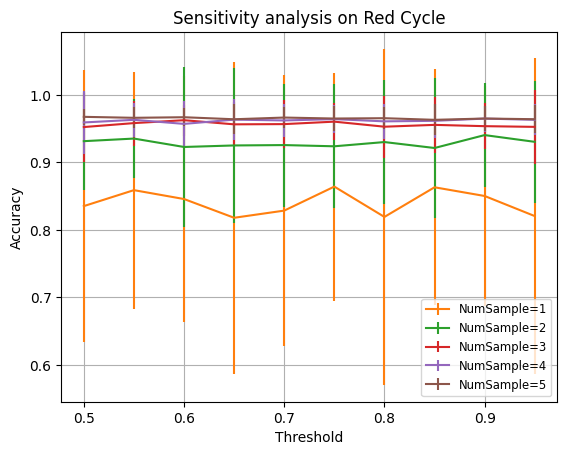

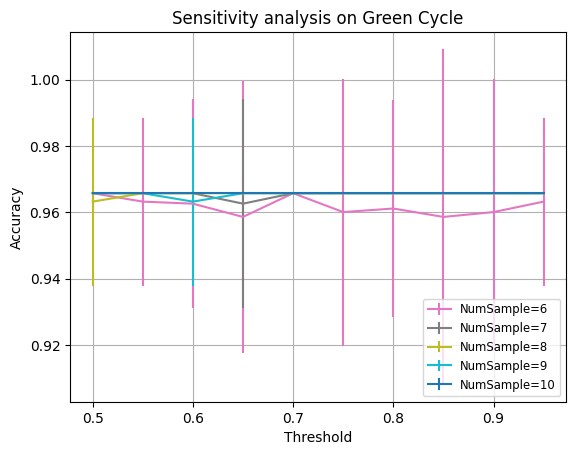

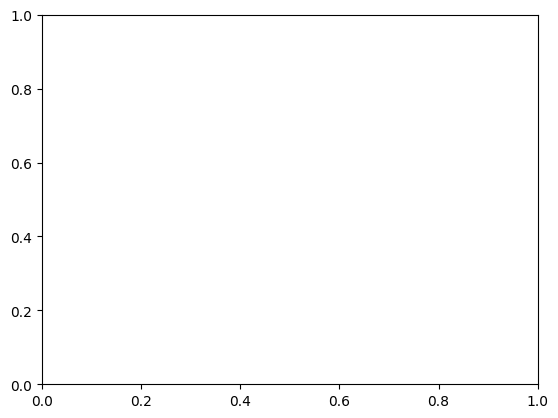

In [ ]:
samplerange=6
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
for numsample in range(1,samplerange):
  threshold=0.5
  Threshold=[]
  Mean1=[]
  Std1=[]
  Mean2=[]
  Std2=[]
  Mean3=[]
  Std3=[]
  while(threshold<1):
    Threshold.append(threshold)
    data1 , data2, data3=Dpc(dataset,threshold)
    X1,Adj1=GraphRep(N,data1)
    X2,Adj2=GraphRep(N,data2)
    X3,Adj3=GraphRep(N,data3)
    mean1,std1=sensitivityanalysis(X1,Adj1,N,numsample,0)
    Mean1.append(mean1)
    Std1.append(std1)
    mean2,std2=sensitivityanalysis(X2,Adj2,N,numsample+5,1)
    Mean2.append(mean2)
    Std2.append(std2)
    # mean3,std3=sensitivityanalysis(X3,Adj3,N,numsample,2)
    # Mean3.append(mean3)
    # Std3.append(std3)
    threshold+=0.05
  plot_mean_with_error(Mean1,Std1,Threshold,label='class1',numsample=numsample,title='Sensitivity analysis on Red Cycle',ax=ax1)
  plot_mean_with_error(Mean2,Std2,Threshold,label='class2',numsample=numsample+5,title='Sensitivity analysis on Green Cycle',ax=ax2)
  # plot_mean_with_error(Mean3,Std3,Threshold,label='class3',numsample=numsample,title='Sensitivity analysis on Acyclic',ax=ax3)

plt.show()



# Function to Calculate whether two classes share a decision boundary

In [ ]:
import torch
import torch.nn.functional as F
import random

def adjacency_score(model,classifier, data_list1, data_list2, class_indices, num_samples=1000, steps=1000):
    """
    Calculate adjacency score between two classes.

    Args:
        model (torch.nn.Module): Pre-trained model for classifying embeddings.
        embeddings_list1 (list): List of embeddings for class 1.
        embeddings_list2 (list): List of embeddings for class 2.
        target_class_index (int): Index of the target class for adjacency check.
        num_samples (int): Number of samples to draw from each list for checking.
        steps (int): Number of steps for linear interpolation.

    Returns:
    return score      int: 1 if classes are adjacent, 0 otherwise.
    """
    adjmeasure=0
      # Assume classes are adjacent initially
    with torch.no_grad():
        for _ in range(num_samples):
            # Randomly sample an embedding from each list
            data1 = random.choice(data_list1)
            data2 = random.choice(data_list2)
            emb1,out1=model(data1.x,data1.edge_index,data1.edge_attr,None)
            emb2,out2=model(data2.x,data2.edge_index,data2.edge_attr,None)
            score=1

            # Convert to tensors if they're not already
            if not isinstance(emb1, torch.Tensor):
                emb1 = torch.tensor(emb1, dtype=torch.float32)
            if not isinstance(emb2, torch.Tensor):
                emb2 = torch.tensor(emb2, dtype=torch.float32)

            for alpha in torch.linspace(0, 1, steps):
                # Create a linear combination of the embeddings
                combination = alpha * emb1 + (1 - alpha) * emb2

                # Pass the combination through the model to get probabilities
                output = classifier(combination)  # Add batch dimension
                #print(output)
                probabilities = F.softmax(output, dim=1)
                #print(probabilities)

                # Check if the maximum probability belongs to the target class
                if probabilities.argmax(dim=1).item() not in class_indices:
                    score = 0
                    break;
            adjmeasure+=score

    return adjmeasure/num_samples




# Function to Approximate the Boundary Generative Distribution and Sample from it

In [ ]:
def boundarysampler(class_indices,N, AdjList=AllAdj,Xlist=AllAdj,numtrials=100,numsample=100,pmix=0.5):
  label1=class_indices[0]
  label2=class_indices[1]
  print(label1,label2)
  X1=AllX[label1]
  X2=AllX[label2]
  Adj1=AdjList[label1]
  Adj2=AdjList[label2]
  X=pmix*X1+(1-pmix)*X2
  Adj=pmix*Adj1+(1-pmix)*Adj2
  accuracies=[]
  embeddings=[]
  acc2=[]
  for _ in range(numtrials):
    min_difference = float('inf')
    sample_accuracy = None
    sample_embedding = None

    for _ in range(numsample):
        out, _, embedding,*_ = GraphSampler(N, X, Adj, show=False)
        probabilities=F.softmax(out,dim=1)

        # Difference in class scores
        score_diff = abs(probabilities[0][label1] - probabilities[0][label2])

        if score_diff < min_difference:
            min_difference = score_diff
            print(probabilities)
            sample_accuracy = probabilities[0][label1]
            otheracc=1-probabilities[0][label1]
            sample_embedding = embedding

    accuracies.append(sample_accuracy)
    acc2.append(otheracc)
    embeddings.append(sample_embedding)

  # Calculate mean and standard deviation of accuracies
  mean_accuracy = torch.mean(torch.tensor(accuracies))
  mean_acc2=torch.mean(torch.tensor(acc2))
  std_accuracy = torch.std(torch.tensor(accuracies))
  return mean_accuracy,mean_acc2, std_accuracy, embeddings


# First find out whether two classes share a boundary by computing their adjacency score. If the score is above 0.9, consider that they share a boundary

In [ ]:
classifier=model.classifier
class_indices=[0,2]
adjscore=adjacency_score(model,classifier,data1,data3,class_indices)
print(adjscore)


1.0


In [ ]:
#class_indices=[0,2]
accuracies,acc2, stdacc, embeddings=boundarysampler([0,2],N,AllAdj,AllX,numtrials=2,numsample=2000)
print(accuracies,acc2)
print(stdacc)

In [ ]:
print(accuracies)

tensor(0.2101)


In [ ]:
# Computing boundary metrics
import torch
import torch.nn.functional as F

def boundary_margin(embeddings_c1, embeddings_c2):
    """
    Compute the boundary margin.

    Args:
    - embeddings_c1 (torch.Tensor): Embeddings of class c1 graphs.
    - embeddings_c2 (torch.Tensor): Embeddings of boundary graphs between class c1 and c2.

    Returns:
    - margin (float): The boundary margin.

    """
    embeddings_c1=torch.cat(embeddings_c1,dim=0)
    embeddings_c2=torch.cat(embeddings_c2,dim=0)
    distances = torch.norm(embeddings_c1 - embeddings_c2, dim=1)
    margin = torch.min(distances).item()
    return margin

def boundary_thickness(embeddings_c1, embeddings_c1_c2, model, c1, c2, gamma=0.75, num_points=100):
    thickness_values = []

    for emb_c1, emb_c1_c2 in zip(embeddings_c1, embeddings_c1_c2):
        t_values = torch.linspace(0, 1, num_points)
        h_t = (1 - t_values).unsqueeze(1) * emb_c1 + t_values.unsqueeze(1) * emb_c1_c2
        #print(model(h_t).size())

        # Compute the logits
        logits_h_t = model(h_t)  # Assuming `model` is your classifier
        probs_h_t = F.softmax(logits_h_t, dim=1)

        # Compute the integrand
        integrand = (gamma > (probs_h_t[:, c1] - probs_h_t[:, c2])).float()

        # Approximate the integral using the trapezoidal rule
        integral = torch.trapz(integrand, t_values)

        # Compute the thickness value
        thickness_value = (emb_c1 - emb_c1_c2).norm() * integral.mean()
        thickness_values.append(thickness_value.item())

    return sum(thickness_values) / len(thickness_values)

# def boundary_complexity(embeddings, D):
#     """
#     Compute the boundary complexity.

#     Args:
#     - embeddings (torch.Tensor): Embeddings of the boundary graphs with shape (num_graphs, embedding_dim).
#     - D (int): Dimensionality of the embeddings.

#     Returns:
#     - complexity (float): The boundary complexity.
#     """
#     # Compute the covariance matrix of the embeddings
#     embeddings=torch.cat(embeddings,dim=0)
#     covariance_matrix = torch.cov(embeddings.T)

#     # Compute the eigenvalues of the covariance matrix
#     eigenvalues = torch.linalg.eigvalsh(covariance_matrix)
#     print(eigenvalues)

#     # Normalize the eigenvalues
#     eigenvalues_normalized = eigenvalues / eigenvalues.sum()
#     print(eigenvalues_normalized)

#     # Compute the entropy of the normalized eigenvalues
#     entropy = -torch.sum(eigenvalues_normalized * torch.log(eigenvalues_normalized + 1e-7))
#     print(entropy)

#     # Normalize the entropy by dividing it by log(D)
#     complexity = entropy / torch.log(torch.tensor(D, dtype=torch.float32))

#     return complexity.item()
def boundary_complexity(embeddings, D, epsilon=1e-7):
    """
    Compute the boundary complexity.

    Args:
    - embeddings (torch.Tensor): Embeddings of the boundary graphs with shape (num_graphs, embedding_dim).
    - D (int): Dimensionality of the embeddings.
    - epsilon (float): Small value added to eigenvalues to prevent log(0).

    Returns:
    - complexity (float): The boundary complexity.
    """
    # Flatten and concatenate embeddings
    embeddings = torch.cat(embeddings, dim=0)

    # Compute the covariance matrix of the embeddings
    covariance_matrix = torch.cov(embeddings.T)

    # Add a small value to the diagonal for regularization
    covariance_matrix += epsilon * torch.eye(covariance_matrix.size(0))

    # Compute the eigenvalues of the covariance matrix
    eigenvalues = torch.linalg.eigvalsh(covariance_matrix)

    # Clamp eigenvalues to avoid very small negative values due to numerical errors
    eigenvalues = torch.clamp(eigenvalues, min=epsilon)

    # Normalize the eigenvalues
    eigenvalues_normalized = eigenvalues / eigenvalues.sum()

    # Compute the entropy of the normalized eigenvalues
    entropy = -torch.sum(eigenvalues_normalized * torch.log(eigenvalues_normalized + epsilon))

    # Normalize the entropy by dividing it by log(D)
    complexity = entropy / torch.log(torch.tensor(D, dtype=torch.float32))

    return complexity.item()

In [ ]:
boundaryembeddings=embeddings
latent_data=latent_data2
margin=boundary_margin(boundaryembeddings[:len(latent_data)],latent_data)
print(margin)
thickness=boundary_thickness(boundaryembeddings[:len(latent_data)],latent_data,model.classifier,1,0)
print(thickness)
complexity=boundary_complexity(boundaryembeddings[:len(latent_data)],64)
print(complexity)

1.846235752105713
64.27653145328725
0.005051757209002972
